In [1]:
import pathos.multiprocessing as multiprocessing
import dill as pickle
from mpl_toolkits.mplot3d import Axes3D

%matplotlib notebook
import matplotlib.pyplot as plt

from py_analyze_tools.sklearn import BasisFunctionConfiguration, ReaDDyElasticNetEstimator

from scipy.integrate import odeint
import py_analyze_tools.tools as pat
import numpy as np
from pprint import pprint
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit

# simple sklearn estimator integration 

In [2]:
traj = pat.Trajectory("../generate/simple_trajectory_.h5")
traj.counts = traj.counts[:45*500]
traj.update()

max counts = 6000.0, min nonzero counts = 1.0


In [3]:
bfc = BasisFunctionConfiguration(traj)
bfc.add_fusion(0, 1, 2)
bfc.add_fission(2, 0, 1)
bfc.add_conversion(0, 1)
bfc.add_conversion(0, 3)
bfc.add_conversion(3, 0)

In [4]:
scale = 1. / (2. * traj.n_species * traj.n_time_steps)
estimator = ReaDDyElasticNetEstimator(traj, bfc, scale, alpha=200, l1_ratio=0.5)

In [5]:
dcounts_dt = np.gradient(traj.counts, axis=0) / traj.time_step
estimator.fit(None, None)

ReaDDyElasticNetEstimator(alpha=200,
             basis_function_configuration=<py_analyze_tools.sklearn.BasisFunctionConfiguration object at 0x7f3762823a90>,
             l1_ratio=0.5, scale=5.555555555555556e-06,
             trajs=[<py_analyze_tools.tools.Trajectory object at 0x7f3797ea2128>])

<IPython.core.display.Javascript object>


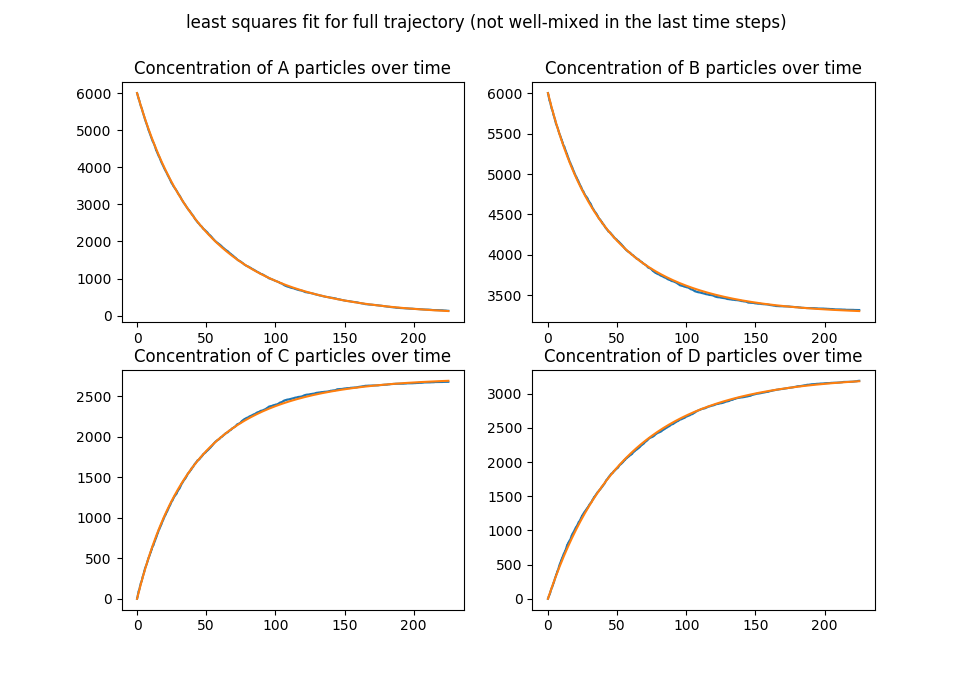

In [6]:
def fun(data, _):
    theta = np.array([f(data) for f in bfc.functions])
    return np.matmul(estimator.coefficients_, theta)
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2)
f.suptitle("least squares fit for full trajectory (not well-mixed in the last time steps)")
num_solution = odeint(fun, traj.counts[0], np.arange(0, traj.n_time_steps*.01, .01))
axes = [ax1, ax2, ax3, ax4]
labels=["A", "B", "C", "D"]
for i in range(traj.n_species):
    axes[i].plot(np.arange(0, traj.n_time_steps*.01, .01), traj.counts[:,i])
    axes[i].plot(np.arange(0, traj.n_time_steps*.01, .01), num_solution[:, i])
    axes[i].set_title("Concentration of %s particles over time" % labels[i])
plt.show()

# grid search

In [7]:
traj = pat.Trajectory("../generate/simple_trajectory_.h5")
traj.counts = traj.counts[:45*500]
traj.update()
bfc = BasisFunctionConfiguration(traj)
bfc.add_fusion(0, 1, 2)
bfc.add_fission(2, 0, 1)
bfc.add_conversion(0, 1)
bfc.add_conversion(0, 3)
bfc.add_conversion(3, 0)
estimator = ReaDDyElasticNetEstimator(traj, bfc, 1. / (2. * traj.n_species * traj.n_time_steps))

max counts = 6000.0, min nonzero counts = 1.0


In [8]:
parameter_grid = {'alpha': np.arange(0, 300, 50), 'l1_ratio': np.arange(0, 1, .2)}
cv = TimeSeriesSplit(3)
gs = GridSearchCV(estimator, parameter_grid, n_jobs=8, cv=cv)

In [9]:
gs.fit(range(0, traj.n_time_steps), y=traj.dcounts_dt)

GridSearchCV(cv=TimeSeriesSplit(n_splits=3), error_score='raise',
       estimator=ReaDDyElasticNetEstimator(alpha=1.0,
             basis_function_configuration=<py_analyze_tools.sklearn.BasisFunctionConfiguration object at 0x7f3762760748>,
             l1_ratio=1.0, scale=5.555555555555556e-06,
             trajs=[<py_analyze_tools.tools.Trajectory object at 0x7f375eead630>]),
       fit_params={}, iid=True, n_jobs=8,
       param_grid={'alpha': array([  0,  50, 100, 150, 200, 250]), 'l1_ratio': array([ 0. ,  0.2,  0.4,  0.6,  0.8])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [10]:
best_est = gs.best_estimator_

In [11]:
best_est.alpha

50

In [12]:
best_est.l1_ratio

0.0

<IPython.core.display.Javascript object>


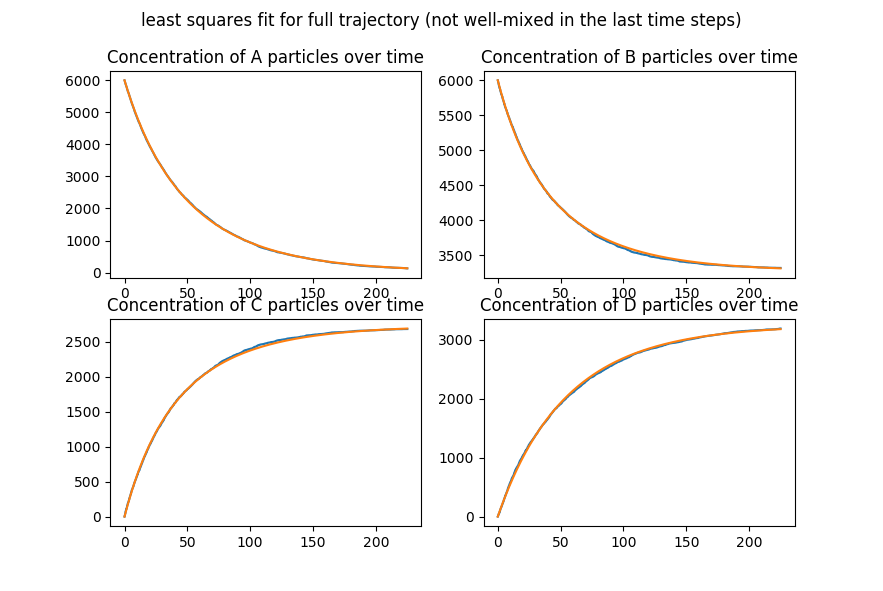

In [13]:
def fun(data, _):
    theta = np.array([f(data) for f in bfc.functions])
    return np.matmul(best_est.coefficients_, theta)
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2)
f.suptitle("least squares fit for full trajectory (not well-mixed in the last time steps)")
num_solution = odeint(fun, traj.counts[0], np.arange(0, traj.n_time_steps*.01, .01))
axes = [ax1, ax2, ax3, ax4]
labels=["A", "B", "C", "D"]
for i in range(traj.n_species):
    axes[i].plot(np.arange(0, traj.n_time_steps*.01, .01), traj.counts[:,i])
    axes[i].plot(np.arange(0, traj.n_time_steps*.01, .01), num_solution[:, i])
    axes[i].set_title("Concentration of %s particles over time" % labels[i])
plt.show()

In [14]:
best_est.coefficients_

array([  1.92476567e-06,   6.25795181e-05,   2.24186415e-06,
         1.02601975e-02,   6.20112881e-05])

In [15]:
import functools
import operator
def rate_info(xi, diffusion_coefficient=.2, microscopic_rate=.05, reaction_radius=.7):
        tmp = np.sqrt(microscopic_rate / diffusion_coefficient) * reaction_radius
        rate_chapman = 4. * np.pi * diffusion_coefficient * reaction_radius * (1. - np.tanh(tmp) / tmp)
        rate_per_volume = xi * functools.reduce(operator.mul, [15,15,15], 1)

        print("erban chapman rate (per volume): {}".format(rate_chapman))
        print("lasso fitted rate (per counts): {}".format(xi))
        print("lasso fitted rate (per volume): {}".format(rate_per_volume))

        return rate_chapman, xi, rate_per_volume

In [16]:
rate_info(best_est.coefficients_)

erban chapman rate (per volume): 0.06848398371542153
lasso fitted rate (per counts): [  1.92476567e-06   6.25795181e-05   2.24186415e-06   1.02601975e-02
   6.20112881e-05]
lasso fitted rate (per volume): [  6.49608414e-03   2.11205874e-01   7.56629150e-03   3.46281666e+01
   2.09288097e-01]


(0.068483983715421526,
 array([  1.92476567e-06,   6.25795181e-05,   2.24186415e-06,
          1.02601975e-02,   6.20112881e-05]),
 array([  6.49608414e-03,   2.11205874e-01,   7.56629150e-03,
          3.46281666e+01,   2.09288097e-01]))

<IPython.core.display.Javascript object>


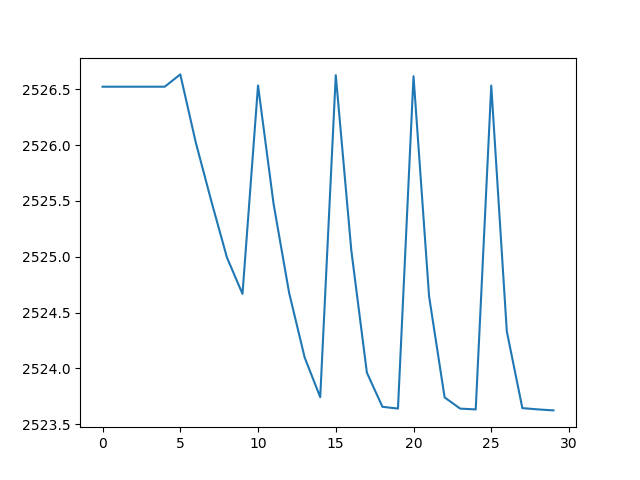

In [17]:
plt.plot(gs.cv_results_['mean_test_score'])

In [18]:
gs.best_params_

{'alpha': 50, 'l1_ratio': 0.0}

<IPython.core.display.Javascript object>


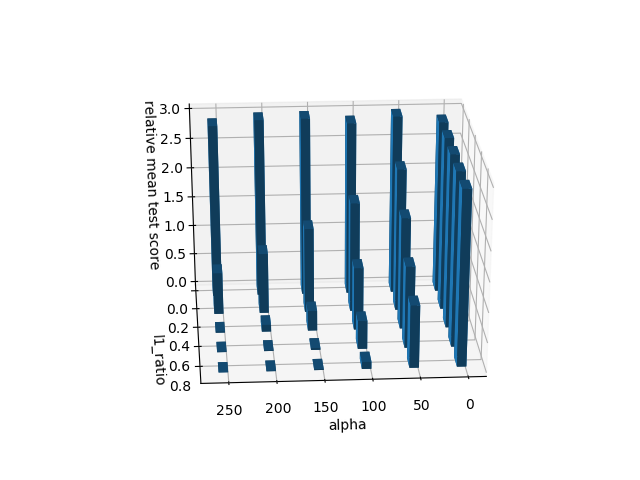

In [19]:

%matplotlib notebook
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
x,y,z = [],[],[]
for idx, param_set in enumerate(gs.cv_results_['params']):
    x.append(param_set['alpha'])
    y.append(param_set['l1_ratio'])
    z.append(gs.cv_results_['mean_test_score'][idx] - np.min(gs.cv_results_['mean_test_score']))
x = np.array(x)
y = np.array(y)
z = np.array(z)
ax.set_xlabel("alpha")
ax.set_ylabel("l1_ratio")
ax.set_zlabel("relative mean test score")
ax.bar3d(x,y,np.zeros(len(z)),10,.1,z)
plt.show()